In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # 基础绘图库（什么都能画，但可能慢、复杂）
import seaborn as sns # 数据可视化专用库（专门用来快速画数据图）
from scipy.optimize import curve_fit
import pingouin as pg


# 中文字体宋体，英文字体新罗马
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['Times New Roman']
# 字体大小
plt.rcParams['font.size'] = 12  
# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False

In [12]:
df1 = pd.read_csv('中间数据集\\多表_按品类\\花菜类.csv')
df2 = pd.read_csv('中间数据集\\多表_按品类\\花叶类.csv')
df3 = pd.read_csv('中间数据集\\多表_按品类\\茄类.csv')
df4 = pd.read_csv('中间数据集\\多表_按品类\\辣椒类.csv')
df5 = pd.read_csv('中间数据集\\多表_按品类\\食用菌.csv')
df6 = pd.read_csv('中间数据集\\多表_按品类\\水生根茎类.csv')

In [13]:
df1.columns

Index(['日期', '单品编码', '单品名称', '分类名称', '销量(千克)', '销售单价(元/千克)', '销售类型', '是否打折销售',
       '批发价格(元/千克)', '损耗率_品类'],
      dtype='object')

## ***计算成本加成定价***

In [14]:
# 按照箱线图规则清除异常值的函数
def remove_outliers(df, column):
    # 计算Q1和Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # 计算IQR
    IQR = Q3 - Q1
    
    # 计算上下限
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 过滤掉异常值
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df


def get_fee(df):

    df = df.drop(['单品名称', '分类名称', '单品编码', '销售类型', '是否打折销售'], axis=1)

    df['日期'] = pd.to_datetime(df['日期'])

    # 计算平均利润
    df['平均利润'] = (df['销售单价(元/千克)'] - df['批发价格(元/千克)']) * df['销量(千克)']
    
    # 计算平均利润率，避免负利润率
    df['平均利润率'] = (df['销售单价(元/千克)'] - df['批发价格(元/千克)']) / df['批发价格(元/千克)']
    
    # 将负利润率设置为0，以避免计算负数的加成率
    df['平均利润率'] = df['平均利润率']#.apply(lambda x: max(x, 0))
    
    # 计算加成率，避免分母为0
    df['加成率'] = df['平均利润率']#.apply(lambda x: x / (1 - x) if x < 1 else float('inf'))
    
    # 计算成本加成定价
    df['成本加成定价'] = df['批发价格(元/千克)'] * (1 + df['加成率'])
    
    # 如果成本加成定价大于批发价的1.75倍，则将成本加成定价设置为批发价的1.75倍
    max_allowed_price = df['批发价格(元/千克)'] * 1.75
    df['成本加成定价'] = df['成本加成定价'].where(df['成本加成定价'] <= max_allowed_price, max_allowed_price)

    df = df.drop(['平均利润', '平均利润率', '加成率'], axis=1)

    # 对时序数据进行聚合 resample
    df_final = df.resample('D', on='日期').agg({
        '销量(千克)': 'sum',
        '销售单价(元/千克)': 'mean',
        '批发价格(元/千克)': 'mean',
        '损耗率_品类': 'mean',    
        '成本加成定价': 'mean'
    })

    # df_final['成本加成定价'].fillna(df_final['成本加成定价'].mean(), inplace=True)
    df_final = remove_outliers(df_final, '销量(千克)')
    df_final = remove_outliers(df_final, '成本加成定价')

    return df_final

In [15]:
df_1 = get_fee(df1)
df_1.to_csv("中间数据集\\按品类的日粒度时序数据集\\花菜类.csv")

df_2 = get_fee(df2)
df_2.to_csv("中间数据集\\按品类的日粒度时序数据集\\花叶类.csv")

df_3 = get_fee(df3)
df_3.to_csv("中间数据集\\按品类的日粒度时序数据集\\茄类.csv")

df_4 = get_fee(df4)
df_4.to_csv("中间数据集\\按品类的日粒度时序数据集\\辣椒类.csv")

df_5 = get_fee(df5)
df_5.to_csv("中间数据集\\按品类的日粒度时序数据集\\食用菌.csv")

df_6 = get_fee(df6)
df_6.to_csv("中间数据集\\按品类的日粒度时序数据集\\水生根茎类.csv")

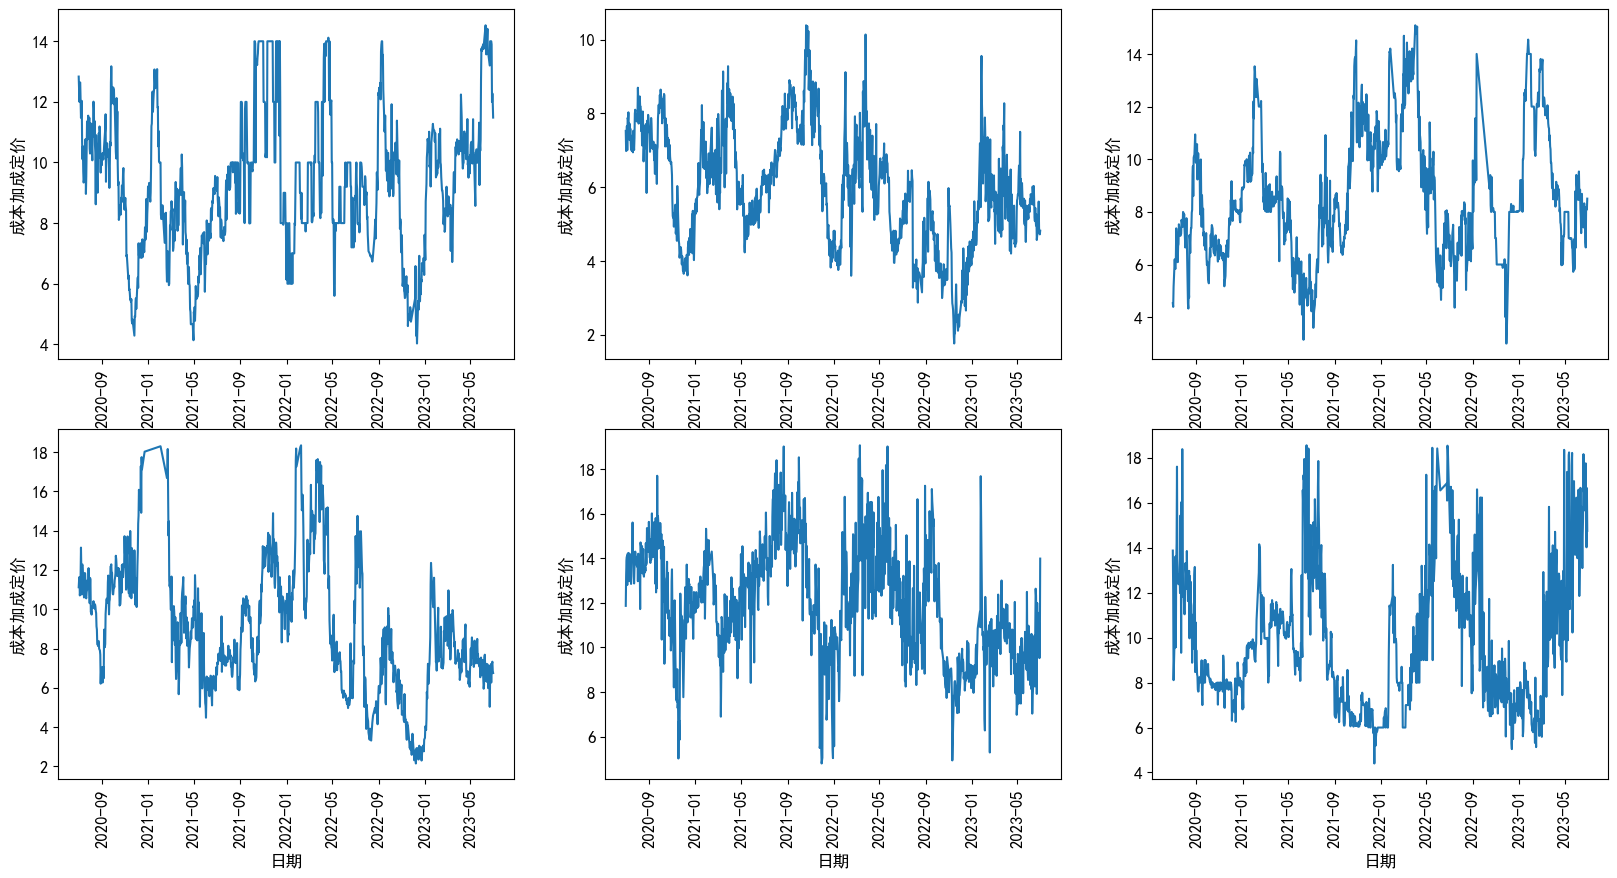

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

ax[0][0].plot(df_1.index, df_1['成本加成定价'])
ax[0][1].plot(df_2.index, df_2['成本加成定价'])
ax[0][2].plot(df_3.index, df_3['成本加成定价'])
ax[1][0].plot(df_4.index, df_4['成本加成定价'])
ax[1][1].plot(df_5.index, df_5['成本加成定价'])
ax[1][2].plot(df_6.index, df_6['成本加成定价'])

for i in range(2):
    for j in range(3):
        ax[i][j].set_xlabel('日期')
        ax[i][j].set_ylabel('成本加成定价')
        # 旋转90度
        ax[i][j].tick_params(axis='x', rotation=90)

## ***探究定性关系***

In [17]:
corr1 = pg.corr(df_1['销量(千克)'], df_1['成本加成定价']).round(3)
corr2 = pg.corr(df_2['销量(千克)'], df_2['成本加成定价']).round(3)
corr3 = pg.corr(df_3['销量(千克)'], df_3['成本加成定价']).round(3)
corr4 = pg.corr(df_4['销量(千克)'], df_4['成本加成定价']).round(3)
corr5 = pg.corr(df_5['销量(千克)'], df_5['成本加成定价']).round(3)
corr6 = pg.corr(df_6['销量(千克)'], df_6['成本加成定价']).round(3)

result_corr = pd.DataFrame({
    '花菜类': corr1.values.flatten(),
    '花叶类': corr2.values.flatten(),
    '茄类': corr3.values.flatten(),
    '辣椒类': corr4.values.flatten(),
    '食用菌': corr5.values.flatten(),
    '水生根茎类': corr6.values.flatten()
}, index=corr1.columns
)
result_corr

,花菜类,花叶类,茄类,辣椒类,食用菌,水生根茎类
n,1013,1056,1008,969,1038,1013
r,-0.262,-0.178,-0.285,-0.341,-0.414,-0.365
CI95%,"[-0.32, -0.2]","[-0.24, -0.12]","[-0.34, -0.23]","[-0.4, -0.28]","[-0.46, -0.36]","[-0.42, -0.31]"
p-val,0.0,0.0,0.0,0.0,0.0,0.0
BF10,1.6e+14,8.602e+05,1.008e+17,3.625e+24,6.181e+40,7.679e+29
power,1.0,1.0,1.0,1.0,1.0,1.0


In [18]:
result_corr.to_excel("结果\\2_1_销量-成本加成定价的定性关系.xlsx")

## ***探究数量关系***

In [19]:
# 一次函数
def func_1(x, a, b):
    return a * x  + b

def func_2(x, a, b):
    return a * np.exp(b * x)

params_quad1, _ = curve_fit(func_1, df_1['销量(千克)'], df_1['成本加成定价'])
df_1['预测值'] = func_1(df_1['销量(千克)'], *params_quad1)

params_quad2, _ = curve_fit(func_1, df_2['销量(千克)'], df_2['成本加成定价'])
df_2['预测值'] = func_1(df_2['销量(千克)'], *params_quad2)

params_quad3, _ = curve_fit(func_1, df_3['销量(千克)'], df_3['成本加成定价'])
df_3['预测值'] = func_1(df_3['销量(千克)'], *params_quad3)

params_quad4, _ = curve_fit(func_1, df_4['销量(千克)'], df_4['成本加成定价'])
df_4['预测值'] = func_1(df_4['销量(千克)'], *params_quad4)

params_quad5, _ = curve_fit(func_1, df_5['销量(千克)'], df_5['成本加成定价'])
df_5['预测值'] = func_1(df_5['销量(千克)'], *params_quad5)

params_quad6, _ = curve_fit(func_1, df_6['销量(千克)'], df_6['成本加成定价'])
df_6['预测值'] = func_1(df_6['销量(千克)'], *params_quad6)

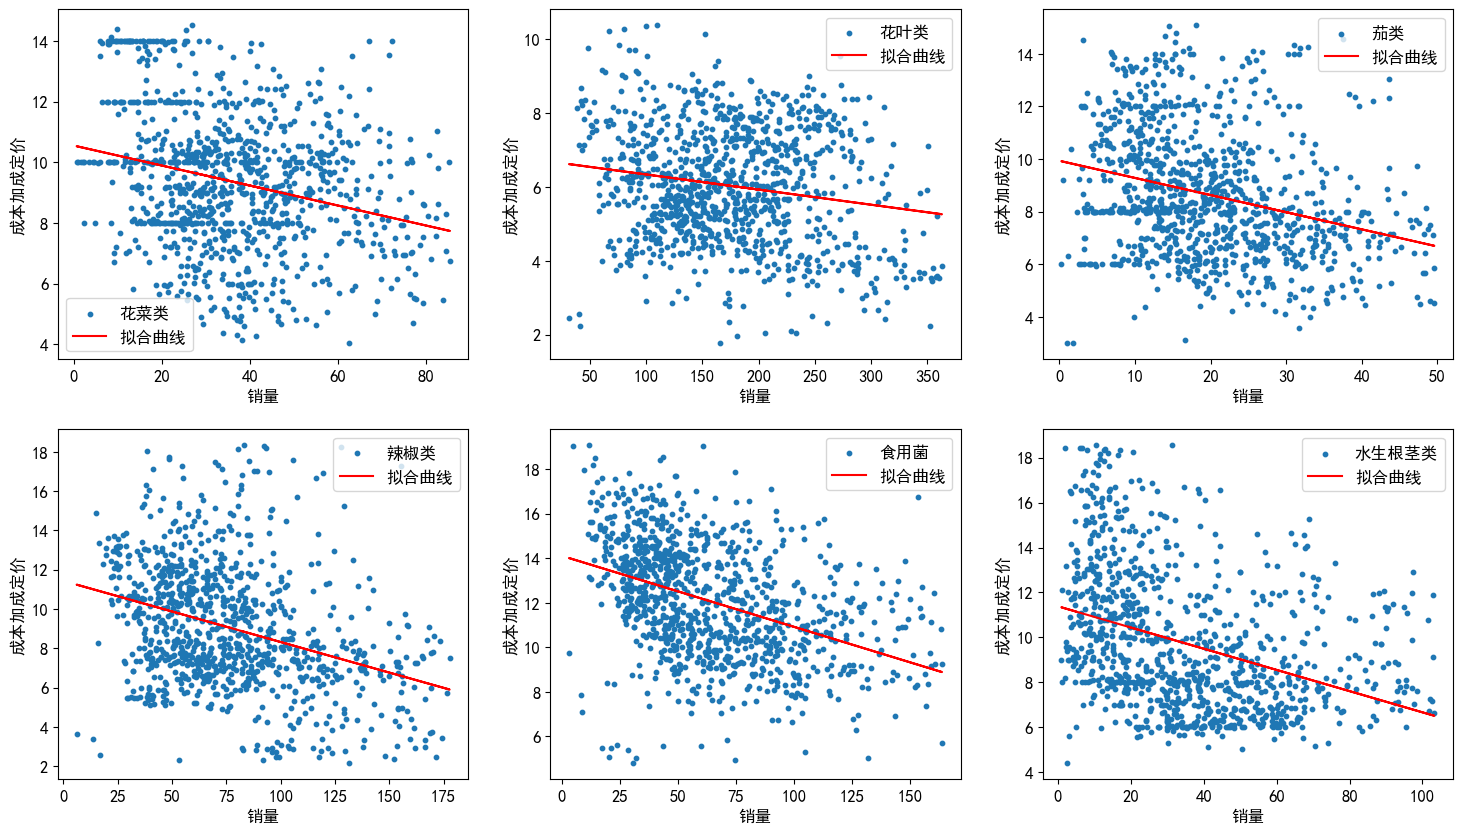

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# 不错
ax[0][0].scatter(df_1['销量(千克)'], df_1['成本加成定价'], s=10, label='花菜类')
ax[0][0].plot(df_1['销量(千克)'], df_1['预测值'], color='red', label='拟合曲线')

ax[0][1].scatter(df_2['销量(千克)'], df_2['成本加成定价'], s=10, label='花叶类')
ax[0][1].plot(df_2['销量(千克)'], df_2['预测值'], color='red', label='拟合曲线')

ax[0][2].scatter(df_3['销量(千克)'], df_3['成本加成定价'], s=10, label='茄类')
ax[0][2].plot(df_3['销量(千克)'], df_3['预测值'], color='red', label='拟合曲线')

ax[1][0].scatter(df_4['销量(千克)'], df_4['成本加成定价'], s=10, label='辣椒类')
ax[1][0].plot(df_4['销量(千克)'], df_4['预测值'], color='red', label='拟合曲线')

ax[1][1].scatter(df_5['销量(千克)'], df_5['成本加成定价'], s=10, label='食用菌')
ax[1][1].plot(df_5['销量(千克)'], df_5['预测值'], color='red', label='拟合曲线')

# 不错
ax[1][2].scatter(df_6['销量(千克)'], df_6['成本加成定价'], s=10, label='水生根茎类')
ax[1][2].plot(df_6['销量(千克)'], df_6['预测值'], color='red', label='拟合曲线')

for i in range(0, 2):
    for j in range(0, 3):
        ax[i][j].legend()
        ax[i][j].set_xlabel('销量')
        ax[i][j].set_ylabel('成本加成定价')

In [21]:
result = pd.DataFrame({'花菜类': params_quad1, 
                '花叶类': params_quad2, 
                '茄类': params_quad3, 
                '辣椒类': params_quad4, 
                '食用菌': params_quad5, 
                '水生根茎类': params_quad6
                }, index=['a', 'b'])
result

,花菜类,花叶类,茄类,辣椒类,食用菌,水生根茎类
a,-0.032953,-0.004100,-0.065122,-0.031069,-0.031848,-0.047177
b,10.550579,6.749194,9.931930,11.426110,14.098714,11.385178


In [22]:
result.to_excel('中间数据集\\销量-成本加成定价线性关系.xlsx')